# Visualising outbreak curves

## Reading and cleaning  the data

Import things

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib as mpl
import os
import pylab as plt

import seaborn as sns
sns.set(style="darkgrid")

In [ ]:
pwd

Identify the input files and read them in

In [ ]:
namepart = "0.016_15_180_123456"#"0.06_100_12345"#_interrupted"#notravellers"
results_filename = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/java/WorldBankCovid19/results_" + namepart + ".txt"


Infections available too!

In [ ]:
#infections_filename = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/java/WorldBankCovid19/infections" + namepart + ".txt"
#i_data = pd.read_csv(infections_filename, sep='\t')

In [ ]:
r_data = pd.read_csv(results_filename, sep='\t')
r_data['districtId'] = [int(str(x).split('_')[1]) for x in r_data["myId"]]


You can aggregate these and write them out to a file for visualisation in QGIS, if you so choose

In [ ]:
r_data

In [ ]:
r_agg = r_data.groupby('districtId').agg({'metric_died_count': 'max', 'metric_new_hospitalized': 'sum', 
                                    'metric_new_critical': 'sum', 'metric_new_cases_asympt': 'sum',
                                    'metric_new_cases_sympt': 'sum'})
#r_agg = r_agg[r_agg['metric_new_cases_sympt'] > 5].sort_values(by='metric_new_cases_sympt', ascending=False)
#r_agg.to_csv("totalSympt.csv", sep=',')

In [ ]:
r_agg[r_agg["metric_new_critical"] > 0]

Lazier aggregation also available

In [ ]:
sum(r_data['metric_new_cases_sympt'])

## Graphing the outbreak curves

In [ ]:
r_cum = r_data.groupby('time').agg({'metric_died_count': 'max', 'metric_new_hospitalized': 'sum', 
                                    'metric_new_critical': 'sum', 'metric_new_cases_asympt': 'sum',
                                    'metric_new_cases_sympt': 'sum'})
r_cum["index"] = r_cum.index
r_cum

Country-level

In [ ]:
r_country_agg = r_data.groupby('time').agg({'metric_died_count': 'max', 'metric_new_hospitalized': 'sum', 
                                    'metric_new_critical': 'sum', 'metric_new_cases_asympt': 'sum',
                                    'metric_new_cases_sympt': 'sum'})

lineListWeightingFactor = 15
r_country_agg['metric_new_cases_detected'] = r_country_agg['metric_new_cases_sympt'] / lineListWeightingFactor

#sns.scatterplot(
fig, ax = plt.subplots (figsize = (15,15))
sns.lineplot(
             x="time", 
             #y="metric_new_deaths",
             #y="metric_new_hospitalized",
             y="metric_new_cases_detected", 
             palette="colorblind", 
             ax = ax,
             data=r_country_agg#,
#            legend=False
            )#.legend(bbox_to_anchor= (1.03, 1) )

#ax.set_title('New Deaths', fontsize=20)
#ax.set_ylabel('Number of deaths')
#ax.legend(fontsize=10, title_fontsize=30, loc='upper left')
#ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#ax.patch.set_alpha(0)
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)
plt.xticks(rotation=45)
plt.tight_layout()

# Mapping results

In [ ]:
import geopandas
import math

In [ ]:
#path_to_data = geopandas.datasets.get_path()
rawLocs = geopandas.read_file("/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/raw/shapefiles/new_districts/ZWE_adm2.shp")
trunkRoads = geopandas.read_file("/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/raw/shapefiles/osm_trunk_roads.shp")

Join this with the previous data!

In [ ]:
dataLocs = rawLocs.merge(r_agg, how="left", left_on=['ID_2'], right_on=['districtId'])

In [ ]:
dataLocs["log_died"] = [max(0, math.log10(max(y, .00000001))) for y in dataLocs["metric_died_count"]]
dataLocs["log_sympt"] = [max(0, math.log10(max(y, .00000001))) for y in dataLocs["metric_new_cases_sympt"]]


In [ ]:
fig, ax = plt.subplots (figsize = (15,15))
#dataLocs.plot("metric_new_cases_sympt", ax = ax, legend=True)
dataLocs.plot("log_sympt", ax = ax, legend=True)

trunkRoads.plot(ax=ax, color="cyan")


COMPARE TO [this](https://ourworldindata.org/covid-deaths)

## Ordering of Districts

### Observing while running

Progress can be observed as they're running - just add the file to which the simulation is exporting below!

**NOTE: MAKE SURE YOU HAVE A TEXT FILE IN THE SAME DIRECTORY AS THIS FILE CONTAINING THE 'TRUE' ORDER OF FILES!**

This file should be formatted as follows:

```
day	districtId
1	1
1	2
...
```

Please note that it is TAB DELIMITED - if your data is not, then you will need to update the csv readin below.

In [ ]:
# set my path when running the file from here

from os.path import isfile, join
path = '/Users/sophieayling/Documents/GitHub/Disease-Modelling-SSA/data/output/'

# read and clean the data
results_filename = (path+'exportMe9927.txt')
r_data = pd.read_csv(results_filename, sep='\t')
r_data['districtId'] = [int(str(x).split('_')[1]) for x in r_data["myId"]] # she is renaming districtid myId


# filter out case data
cases = r_data[(r_data.metric_new_cases_sympt > 0) | (r_data.metric_new_cases_asympt > 0)]
cases.head()

# group by districts and sort by time
byDistric = cases.groupby('districtId').agg({'time': 'min'})
byDistric.sort_values(by="time")

# sophie adding want to rename 'time' to denote the day of simulation
byDistric.rename(columns={'time':'simDay'}, inplace=True)

byDistric.head()

# read in the first districts cases data (what she called 'gold standard data')
gold_filename = (path+"../preprocessed/line_list/true.txt")
g_data = pd.read_csv(gold_filename, sep='\t')
g_data["trueDay"] = [int(x) for x in g_data['day']] ## Sophie not using this 

# join the simulated and gold standard data based on the district ID
comparison = g_data.join(byDistric, on='districtId', lsuffix='_gold', rsuffix='_sim')
comparison['simDay'] = comparison['simDay'].fillna(0) # you may wish to set the unfound districts to some default
#comparison # show the results
comparison.head()
comparison.to_csv(path+'comparison.csv')

In [ ]:
myslice = pd.isna(comparison['simDay']) # see all of the districts where there were cases in both sim and true days 
#print(comparison[-myslice]) # showing the districts where the cases occured in both simulation and true data
both_sa= comparison[-myslice]
myslice.head()

In [ ]:
fig, ax = plt.subplots (figsize = (10,10))
ax= sns.scatterplot(
             x="trueDay", 
             y="simDay",
             #y="metric_new_hospitalized",
             #y="metric_new_cases_sympt", 
             palette="colorblind", 
            # hue="districtId",
             data=comparison, #,
            #legend=True
            )#.legend(bbox_to_anchor= (1.03, 1) )

 # add labels to values on product id
for line in range(0,comparison.shape[0]):
    ax.text(comparison.trueDay[line] +0.01, comparison.simDay[line],
           comparison.districtId[line], horizontalalignment='left',
           size='medium', color='black', weight ='light')

ax.set(xlim=(0, 180), ylim=(0, 180)) # in true day the max first day is 136, in sim the max first day is 179
xl, yl = [0,180], [0,180]
sns.lineplot(xl, yl, linestyle='--', color='red')

### Summarising the results

Sets of simulation results can also be explored in the aggregate.

In [ ]:
outputFiles = ["exportMe9927.txt"]#"exportMe3324.txt", "exportMe4725.txt", "exportMe9812.txt", "exportMe2439.txt", "exportMe5343.txt", 
               #"exportMe6598.txt", "exportMe8992.txt", "exportMe7535.txt", "exportMe217.txt", "exportMe217.txt"]


In [ ]:
# a helper function to read in and order a set of districts
def getOrderedDistricts(filename):
    
    # read and clean the data
    r_data = pd.read_csv(filename, sep='\t')
    r_data['districtId'] = [int(str(x).split('_')[1]) for x in r_data["myId"]]
    
    # select the relevant columns, either cases or deaths
    cases = r_data[(r_data.metric_new_cases_sympt > 0) | (r_data.metric_new_cases_asympt > 0)]
    #cases = r_data[r_data.metric_new_deaths > 0]
    
    # group by districts and sort by time
    byDistric = cases.groupby('districtId').agg({'time': 'min'})
    byDistric.sort_values(by="time")
    return byDistric
    
# read in the gold standard data
gold_filename = "true.txt"
g_data = pd.read_csv(gold_filename, sep='\t')
g_data["trueDay"] = [int(x) for x in g_data['day']]

In [ ]:
# iterate through the set of exported results files and append them to one another

simRuns = pd.NA # intial empty file

for x in outputFiles: # iterating over files
    try:
        simRuns = simRuns.append(getOrderedDistricts(x))
    except:
        simRuns = getOrderedDistricts(x)

# aggregate by the mean time associated with the district
simAgg = simRuns.groupby('districtId').agg({'time': 'mean'})

In [ ]:
# additional helper functions

def getAggDailyCounts(filename):
    r_data = pd.read_csv(filename, sep='\t')
    r_data['districtId'] = [int(str(x).split('_')[1]) for x in r_data["myId"]]
    dailies = r_data.groupby('time').agg({'metric_new_cases_sympt': 'sum', 'metric_new_cases_asympt': 'sum'})
    dailies.sort_values(by="time")
    return dailies

def getRawData(filename):
    r_data = pd.read_csv(filename, sep='\t')
    r_data['districtId'] = [int(str(x).split('_')[1]) for x in r_data["myId"]]
    return r_data

simRuns = pd.NA

for x in outputFiles:
    myCounts = getRawData(x)
    myCounts['key'] = [x for i in range(len(myCounts))]
    try:
        simRuns = simRuns.append(myCounts)
    except:
        simRuns = myCounts

simAgg = simRuns.groupby('time').agg({'metric_new_cases_sympt': 'mean', 'metric_new_cases_asympt': 'mean'})
simAgg.head()

### Mapping the difference between simulated and true timing

In [ ]:
# calculate the delta between true and simulated first recorded cases
comparison['diff'] = comparison['trueDay'] - comparison['simDay']

# read in spatial data
rawLocs = geopandas.read_file("/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/raw/shapefiles/new_districts/ZWE_adm2.shp")
trunkRoads = geopandas.read_file("/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/raw/shapefiles/osm_trunk_roads.shp")

# merge the comparison data with the spatial district data on the district ID
dataLocs = rawLocs.merge(comparison, how="left", left_on=['ID_2'], right_on=['districtId'])

Red = simulated was faster than real

Blue = simulated was slower than real

In [ ]:
myLim = 180

fig, ax = plt.subplots (figsize = (15,15))
dataLocs.plot("diff", ax = ax, legend=True, cmap='seismic', 
              missing_kwds={"color": "gray", "label": "Missing values",}, vmin=-myLim, vmax=myLim)

trunkRoads.plot(ax=ax, color="black")

In [ ]:
outputFiles = ["exportMe5_0.03_.txt"]
filename = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/output/" + outputFiles[0]
r_data = pd.read_csv(filename, sep='\t')


In [ ]:
import os
import pandas as pd
import pylab as plt
import numpy as np

path = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/notebooks/"#"/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/output/"

files = os.listdir(path)

cutoffFromEnd = 6 * (180 - 9)

r_effs = []

# assemble the data from all the files
for f in files:
    if(f.startswith("infections")): # only select the "infection" outputs
        
        print(f)
        # read in the data from the file
        r_data = pd.read_csv(path + f, sep='\t')
        
        # the "Source" data gets read in as a float - just convert it for ease!
        r_data["myHost"] = [float(x) for x in r_data["Host"]]
        
        # omit the people who did not actually have a case (that is, contagion never happened)
        properCases = r_data[r_data["ContagiousAt"] != "1.7976931348623157E308"]
        numProperCases = properCases.shape[0]
        
        # find how many cases have been, thus far, produced
        numSeededCases = sum(pd.isna(properCases["Source"]))
        
        # find out how many people could possibly have produced these
        possibleProducers = properCases["Time"] < cutoffFromEnd
        numPossibleProducers = possibleProducers.shape[0]
        
        #numUnique = np.unique(properCases["Source"])
        r_effs.append(numProperCases / numPossibleProducers)
        
        #plt.plot(r_data["time"][1:], r_data["metric_new_cases_sympt"][1:],'r-', alpha=0.2)
r_effs


In [ ]:
x = [5,0,0,0,0]
y = [1,1,1,1,1]
z = [5,5,5,5,5]

def r_eff(a):
    return sum(a)/len(a)
    
print(r_eff(z))

In [ ]:
r_data

In [ ]:
import os
import pandas as pd
import pylab as plt

path = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/output/"

files = os.listdir(path)

myAvgLine = []
index = 0
for f in files:
    if(f.startswith("exportMe")):
        r_data = pd.read_csv(path + f, sep='\t')
        totcases = r_data["metric_new_cases_sympt"] + r_data["metric_new_cases_asympt"]
        if len(myAvgLine) == 0:
            myAvgLine = totcases
        else:
            myAvgLine += totcases
        plt.plot(r_data["time"][1:], totcases[1:],'r-', alpha=0.15)
        index += 1

myAvgLine2 = []
index2 = 0
for f in files:
    if(f.startswith("exportPerfectThing")):
        r_data = pd.read_csv(path + f, sep='\t')
        totcases = r_data["metric_new_cases_sympt"] + r_data["metric_new_cases_asympt"]
        if len(myAvgLine2) == 0:
            myAvgLine2 = totcases
        else:
            myAvgLine2 += totcases
        plt.plot(r_data["time"][1:], totcases[1:],'b-', alpha=0.15)
        index2 += 1

plt.plot(r_data["time"][1:], myAvgLine[1:]/index,'r', label="Bubbles", alpha=1)
plt.plot(r_data["time"][1:], myAvgLine2[1:]/index2,'b', label="Perfect Mixing", alpha=1)
plt.legend()

plt.savefig(path + "comparisonOfCases.png", dpi=300)


In [ ]:
def plotMetric(files, prefix, suffix, metric, symbol, alpha):
    myAvgLine = []
    index = 0
    template = "^" + prefix + ".*" + suffix + "$"

    for f in files:

        if(re.search(template, f) != None): # f.startswith(prefix) and 
            r_data = pd.read_csv(path + f, sep='\t')
            totcases = r_data[metric]
            if len(myAvgLine) == 0:
                myAvgLine = totcases
            else:
                myAvgLine += totcases
            
            # plot it
            plt.plot(r_data["time"][1:], totcases[1:], symbol, alpha=alpha)
            index += 1
    if(index == 0):
        print("ERROR: files not found!")
        return pd.NA
    return {"myLine": myAvgLine/index, "myTime": r_data["time"]}

path = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/output/"
files = os.listdir(path)

#line1 = plotMetric(files, "exportMe", "0.03_.txt", "metric_new_cases_sympt", 'r-', 0.15)
line2 = plotMetric(files, "exportPerfect", "0.03_.txt", "metric_new_cases_sympt", 'b-', 0.15)
line3 = plotMetric(files, "exportPerfectMixing", "0.1.txt", "metric_new_cases_sympt", 'g-', 0.15)

In [ ]:
import pandas as pd

x = ["exportMe6_0.03_.txt", "exportPerfectMixing_4_0.03.txt", "exportPerfectMixing_7_0.03_.txt", "exportPerfectMixing_5_0.03.txt", "exportPerfectMixing_2_0.03_.txt", "exportMe3_0.03_.txt", "exportPerfectMixing_4_0.03_.txt", "exportMe5_0.03_.txt", "exportPerfectMixing_0_0.03.txt", "exportPerfectMixing_1_0.03.txt", "exportPerfectMixing_9_0.03_.txt", "exportMe8_0.03_.txt", "exportPerfectMixing_0_0.3.txt", "exportMe2_0.03_.txt", "exportPerfectMixing_3_0.03_.txt"]

y = x[0]

In [ ]:
# the number of infections caused in a day over the number of infected individuals

def extractRe(filename):
    r_data = pd.read_csv(filename, sep='\t')
    new_cases = r_data["metric_new_cases_sympt"] + r_data["metric_new_cases_asympt"]
    #for l in r_data["time"]:
    #    print(l)
    print(new_cases)
        
extractRe("/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/output/exportBubblesOf30_9_0.1.txt")

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pylab as plt
from os.path import isfile, join
from glob import glob
import subprocess
import re


import seaborn as sns
sns.set(style="darkgrid")

def plotMetric(files, prefix, suffix, metric, symbol, alpha, weighting=1):
    myAvgLine = []
    index = 0
    template = "^" + prefix + ".*" + suffix + "$"

    for f in files:

        if(re.search(template, f) != None): # f.startswith(prefix) and 
            r_data = pd.read_csv(path + f, sep='\t')
            totcases = r_data[metric]
            if len(myAvgLine) == 0:
                myAvgLine = totcases
            else:
                myAvgLine += totcases
            
            # plot it
            plt.plot(r_data["time"][1:], weighting * totcases[1:], symbol, alpha=alpha)
            index += 1
    return {"myLine": weighting * myAvgLine/index, "myTime": r_data["time"]}

path = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/output/"
files = os.listdir(path)

prefix = "exportBubblesOf30_"
prefix2 = "exportBubbles_20perc"

line1 = plotMetric(files, prefix, "0.016.txt", "metric_new_cases_sympt", 'r-', 0.15, 4)
#line2 = plotMetric(files, prefix2, "0.016.txt", "metric_new_cases_sympt", 'b-', 0.15)

plt.plot(line1["myTime"][1:], line1['myLine'][1:], 'r', label="Bubbles - 5%")
#plt.plot(line2["myTime"][1:], line2['myLine'][1:], 'b', label="Bubbles - 20%")
plt.legend()

plt.savefig(path + "comparisonOfPopulationSizes.png", dpi=300)

### Spread of Infection - Visualising it Phylogenetically

In [1]:
# Importing necessary libraries from BioPython
from Bio import Phylo, AlignIO
import pandas as pd
from io import StringIO 
import matplotlib.pyplot as plt

In [ ]:
results_filename = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/java/WorldBankCovid19/infections_0.1_1_60_1234.txt"
r_data = pd.read_csv(results_filename, sep='\t')

In [ ]:
transmissions = r_data[["Host", "Source"]]
transmissions["Source"] = transmissions["Source"].fillna(0) # get rid of NAs
transmissions["CleanSource"] = [int(x) for x in transmissions["Source"]] # make sure they're all ints

In [ ]:
def getMySubtree(me, myMatrix, amIFirst = True):

    # set up the prefix showing the name of this node
    result = ""

    # if I am not first, add a comma to separate the elements
    if not amIFirst:
        result += ","
        
    # add my ID
    result += " " + "." #str(me)
    
    # get a list of the people for whom I am the source (my 'children')
    mychildren = myMatrix[myMatrix["CleanSource"] == me]

    # if I have children, they will be denoted within the brackets
    if len(mychildren) > 0:
        result += "("
    
    first = True # don't add more commas than necessary
    for idx, childrow in mychildren.iterrows(): # iterate through the rows
        
        #print("getting child " + str(childrow["Host"])) # verbose

        # check if we should add a comma before printing this
        if not first:
            result += ","
        else:
            first = False # if it was the first on this run, it is no longer
        
        # add the subtrees of my children
        result += getMySubtree(childrow["Host"], myMatrix, True)
    
    # if I do have children, close the brackets!
    if len(mychildren) > 0:
        result += ")"
    
    return result

In [ ]:
#transmissions

roots = transmissions[transmissions["CleanSource"] == 0]
myTreeString = ""
for i, r in roots.iterrows():
    myTreeString += getMySubtree(r["Host"], transmissions)
    
print(myTreeString)

In [ ]:
myTree = Phylo.read(StringIO(myTreeString), "newick")

In [ ]:
myTree.root.color = "red"
plt.ioff()
fig = plt.figure()
Phylo.draw(myTree, xlabel=({'xlabel': 'Generations'}), ylabel=({'ylabel': 'Hosts'}), do_show=False)
plt.savefig('exampleSpread.png')
plt.close(fig)


#Phylo.draw(tree, axhspan=((0.25, 7.75), {'facecolor':'0.5'}),

In [ ]:
Phylo.draw_ascii(myTree)

### Comparing the age profile of census, single district, and mobile agents

In [7]:
singDist_filename = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/java/WorldBankCovid19/infections_0.1_1_60_1234_oneDistOneStat.txt"
multiDist_filename = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/java/WorldBankCovid19/infections_0.1_1_60_1234_movementDistricts.txt"
multiD_oneStat_filename = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/java/WorldBankCovid19/infections_0.1_1_60_1234.txt"

singDist_data = pd.read_csv(singDist_filename, sep='\t')
multiDist_data = pd.read_csv(multiDist_filename, sep='\t')
mD1S_data = pd.read_csv(multiD_oneStat_filename, sep='\t')

census_filename = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/preprocessed/census/census_sample_5perc_040521.csv"
census_data = pd.read_csv(census_filename, sep=',')

In [8]:
singDist_data["person_id"] = singDist_data["Host"]
fullSing = singDist_data.merge(census_data, on="person_id", how="left")

multiDist_data["person_id"] = multiDist_data["Host"]
fullMulti = multiDist_data.merge(census_data, on="person_id", how="left")

mD1S_data["person_id"] = mD1S_data["Host"]
fullMD1S = mD1S_data.merge(census_data, on="person_id", how="left")


In [9]:
actualCasesSing = fullSing[fullSing["ContagiousAt"] != "-"]
actualCasesMulti = fullMulti[fullMulti["ContagiousAt"] != "-"]
actualCasesMD1S = fullMD1S[fullMD1S["ContagiousAt"] != "-"]

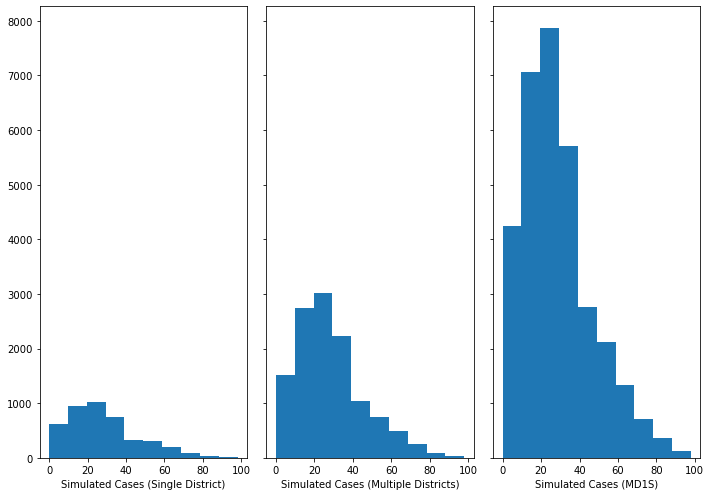

In [11]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(10,7))

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(actualCasesSing["age"], bins=10)
axs[0].set_xlabel('Simulated Cases (Single District)')
#axs[1].hist(census_data["age"], bins=10)
#axs[1].set_xlabel('Census')
axs[1].hist(actualCasesMulti["age"], bins=10)
axs[1].set_xlabel('Simulated Cases (Multiple Districts)')
axs[2].hist(actualCasesMD1S["age"], bins=10)
axs[2].set_xlabel('Simulated Cases (MD1S)')


plt.show()

So we can see that
* overall, the simulated cases skew older
* fewer children, proportionately, are infected in the multi (movement) model than in the single district model


### Correlation between age in district and case rate

In [ ]:
results_filename = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/java/WorldBankCovid19/infections_0.1_1_60_1234.txt"
r_data = pd.read_csv(results_filename, sep='\t')

In [ ]:
x = pd.Series(r_data["LocOfTransmission"])
b = x.value_counts()
b.index

cases = pd.DataFrame(b)
cases["district"] = b.index
cases["num"] = [int(x.split("_")[1]) for x in cases["district"]]
cases.head()

In [ ]:
elderly = census_data[census_data['age'] >= 60]
countElderly = elderly.groupby(["district_id"]).count()
elderlyByDistrict = pd.DataFrame(countElderly["person_id"])
elderlyByDistrict["num"] = countElderly.index

In [ ]:
merged = cases.merge(elderlyByDistrict, on="num", how="left")
merged.head()

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

In [ ]:
xval = np.array(merged["LocOfTransmission"]).reshape(-1, 1)
yval = np.array(merged["person_id"])
model = LinearRegression().fit(xval, yval)
r_sq = model.score(xval, yval)

In [ ]:
r_sq

In [ ]:
y_pred = model.predict(xval)
y_pred

In [ ]:
plt.scatter(xval, y_pred, c="blue")
plt.scatter(xval, yval, c="red")
plt.show()